# Practical Session 3/4 : Flights Dataset Analysis
In this session, we will conduct a few analyses on a simplified flight fares dataset.  
In particular we will try to build cheapest routes from one point to another.

## Grading and Instructions
You must return your notebook before **Wednesday March 2nd 23:59 Paris time** by email to David : d.diebold@criteo.com.  
Grade will be composed of :
1. Timely return
2. Correctness (some questions may still leave you with some liberties)
3. Report formatting : While we allow you to return your project in a notebook format, you should think your report as being a classic text and image pdf report in which the code is in appendix. That means your notebook should be fully readable while hiding all the code cells.
4. Code Readability (factorized code, well-named variables, explain what you do when code becomes complicated, etc...)
5. Performance (this is not a race but we want you to think about performance issues when designing your solution (shuffles, etc...). Don't hesitate to annotate your notebook with any remarks about your solution.


## Install Spark Environment
Since we are not running on databricks, we will need to install Spark by ourselves, every time we run the session.  
We need to install Spark, as well as a Java Runtime Environment.  
Then we need to setup a few environment variables.  


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!curl -O https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  287M  100  287M    0     0   198M      0  0:00:01  0:00:01 --:--:--  198M


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

## Optional step : Enable SparkUI through secure tunnel
This step is useful if you want to look at Spark UI.
First, you need to create a free ngrok account : https://dashboard.ngrok.com/login.  
Then connect on the website and copy your AuthToken.


In [ ]:
# this step downloads ngrok, configures your AuthToken, then starts the tunnel
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!./ngrok authtoken my_ngrok_auth_token_retrieved_from_website # <-------------- change this line !
get_ipython().system_raw('./ngrok http 4050 &')

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


Now get the Spark UI url on https://dashboard.ngrok.com/endpoints/status. We're done !

## Useful imports

In [4]:
import time
import numpy as np
import pyspark.sql.functions as F
%matplotlib inline

## Introduction
Aim of this notebook is to help you get comfortable with Spark Dataframe API while working on a flights dataset.  
This dataset contains some domestic flight prices for US country.  
We will call route a tuple identified by an origin airport and a destination airport.  
We will try to find-out what are the best options for a traveler, to go from some place to another.  
Here is a short description of the columns:
- ItinID & MktID: vaguely demonstrates the order in which tickets were ordered (lower ID #'s being ordered first)
- MktCoupons: the number of coupons in the market for that flight
- Quarter: 1, 2, 3, or 4, all of which are in 2018
- Origin: the city out of which the flight begins
- OriginWac: USA State/Territory World Area Code
- Dest: the city out of which the flight begins
- DestWac: USA State/Territory World Area Code
- Miles: the number of miles traveled
- ContiguousUSA: binary column -- (2) meaning flight is in the contiguous (48) USA states, and (1) meaning it is not (ie: Hawaii, Alaska, off-shore territories)
- NumTicketsOrdered: number of tickets that were purchased by the user
- Airline Company: the two-letter airline company code that the user used from start to finish (key codes below)
- PricePerTicket: ticket price

In [5]:
# download the dataset described above
from urllib import request
import zipfile

url = "https://www.dropbox.com/s/kda4h5su4z6go05/flights.zip?dl=1"
filehandle, _ = request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.extractall()

In [6]:
# This seond file contains a mapping with airports Code / Name / Latitude / Longitude
# It can help to get a better understanding of the airports you are dealing with.
# Source : https://www.partow.net/miscellaneous/airportdatabase/index.html#Downloads
url2 = "https://www.dropbox.com/s/xe2a3hgwlugos7a/GlobalAirportDatabase.txt?dl=1"
request.urlretrieve(url2, "airport_latlon.txt")

('airport_latlon.txt', <http.client.HTTPMessage at 0x7fbc6a291150>)

In [7]:
!ls

airport_latlon.txt	  spark-3.2.1-bin-hadoop3.2
Cleaned_2018_Flights.csv  spark-3.2.1-bin-hadoop3.2.tgz
sample_data


## Question 1 (1 point)
Display a few rows of the flights fare dataset, display it's schema, and count the amount of rows.  
You are likely to read this dataset a lots of times ; rewrite the dataset on the file system in an optimized way, to optimize further readings.  

In [8]:
flights_df = spark.read.options(header=True, inferSchema=True).csv("Cleaned_2018_Flights.csv")
flights_df.write.parquet("flights.parquet")

In [9]:
flights_df = spark.read.parquet("flights.parquet")
flights_df.show(5)

+---+-----------+-------------+----------+-------+------+---------+----+-------+------+-------------+-----------------+--------------+--------------+
|_c0|     ItinID|        MktID|MktCoupons|Quarter|Origin|OriginWac|Dest|DestWac| Miles|ContiguousUSA|NumTicketsOrdered|AirlineCompany|PricePerTicket|
+---+-----------+-------------+----------+-------+------+---------+----+-------+------+-------------+-----------------+--------------+--------------+
|  0|20181767585|2018176758501|         1|      1|   PHL|       23| LAX|     91|2402.0|            2|              1.0|            AA|        672.87|
|  1|20181767586|2018176758601|         1|      1|   PHL|       23| LAX|     91|2402.0|            2|              1.0|            AA|        367.68|
|  2|20181767587|2018176758701|         1|      1|   PHL|       23| LAX|     91|2402.0|            2|              1.0|            AA|        417.94|
|  3|20181767636|2018176763601|         1|      1|   PHL|       23| LAX|     91|2402.0|            2

In [ ]:
flights_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ItinID: long (nullable = true)
 |-- MktID: long (nullable = true)
 |-- MktCoupons: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestWac: integer (nullable = true)
 |-- Miles: double (nullable = true)
 |-- ContiguousUSA: integer (nullable = true)
 |-- NumTicketsOrdered: double (nullable = true)
 |-- AirlineCompany: string (nullable = true)
 |-- PricePerTicket: double (nullable = true)



In [ ]:
print(f"Amount of rows : {flights_df.count()}")

Amount of rows : 9534417


## Question 2 (4 points)  
Find how many origin and destination airports are contained in the dataset.  
Show them on a US map to get a better intuition of the dataset. You can use shapely and geopandas to perform this task.  
Do we have all the lat/lon available ?

In [10]:
nb_origin_airports = flights_df.select('Origin').distinct().count()
print(f"Origin Airports : {nb_origin_airports}")

Origin Airports : 263


In [11]:
nb_dest_airports = flights_df.select('Dest').distinct().count()
print(f"Destination Airports : {nb_dest_airports}")

Destination Airports : 260


In [12]:
# loading mapping dataset. 
# csv does not contain any column, we need to name them manually.
airports_latlon_df = (
    spark
    .read
    .options(header=False, inferSchema=True, delimiter=':')
    .csv("airport_latlon.txt")
    .withColumnRenamed("_c1", "iata_code")
    .withColumnRenamed("_c4", "country")
    .withColumnRenamed("_c14", "lat")
    .withColumnRenamed("_c15", "lon")
    .filter("iata_code!='N/A'")
    .filter("country='USA'")
    .filter("lat!=0.0")
    .filter("lon!=0.0")
)

In [13]:
airports_latlon_df.show(5)

+----+---------+--------------------+-------------+-------+---+---+---+---+---+----+----+----+----+------+-------+
| _c0|iata_code|                 _c2|          _c3|country|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|   lat|    lon|
+----+---------+--------------------+-------------+-------+---+---+---+---+---+----+----+----+----+------+-------+
|KABI|      ABI|        ABILENE RGNL|      ABILENE|    USA| 32| 24| 40|  N| 99|  40|  54|   W| 546|32.411|-99.682|
|KACK|      ACK|       NANTUCKET MEM|    NANTUCKET|    USA| 41| 15| 10|  N| 70|   3|  36|   W|  15|41.253| -70.06|
|KACT|      ACT|           WACO RGNL|         WACO|    USA| 31| 36| 40|  N| 97|  13|  49|   W| 158|31.611| -97.23|
|KACY|      ACY|ATLANTIC CITY INT...|ATLANTIC CITY|    USA| 39| 27| 27|  N| 74|  34|  37|   W|  23|39.458|-74.577|
|KADM|      ADM|        ARDMORE MUNI|      ARDMORE|    USA| 34| 18| 11|  N| 97|   1|  10|   W| 233|34.303|-97.019|
+----+---------+--------------------+-------------+-------+---+---+---+---+---+-

In [14]:
distinct_airports_df = (
    flights_df.select(F.col('Origin').alias('Airport')).distinct()
    .union(flights_df.select(F.col('Dest').alias('Airport')).distinct())
    .distinct()
    .cache()
    )

In [15]:
distinct_airports_with_latlon_df = (
    distinct_airports_df
      .join(airports_latlon_df.withColumnRenamed("iata_code", "Airport"), on="Airport")
      .cache()
    )

In [16]:
found = distinct_airports_with_latlon_df.collect()
all_origins = distinct_airports_df.count()
print(f"Airports with Lat/Lon found : {len(found)} out of {all_origins}")

Airports with Lat/Lon found : 167 out of 270


In [17]:
pd_df = distinct_airports_with_latlon_df.select('Airport', 'lat', 'lon').distinct().toPandas()

In [18]:
!pip install shapely > /dev/null
!pip install geopandas > /dev/null

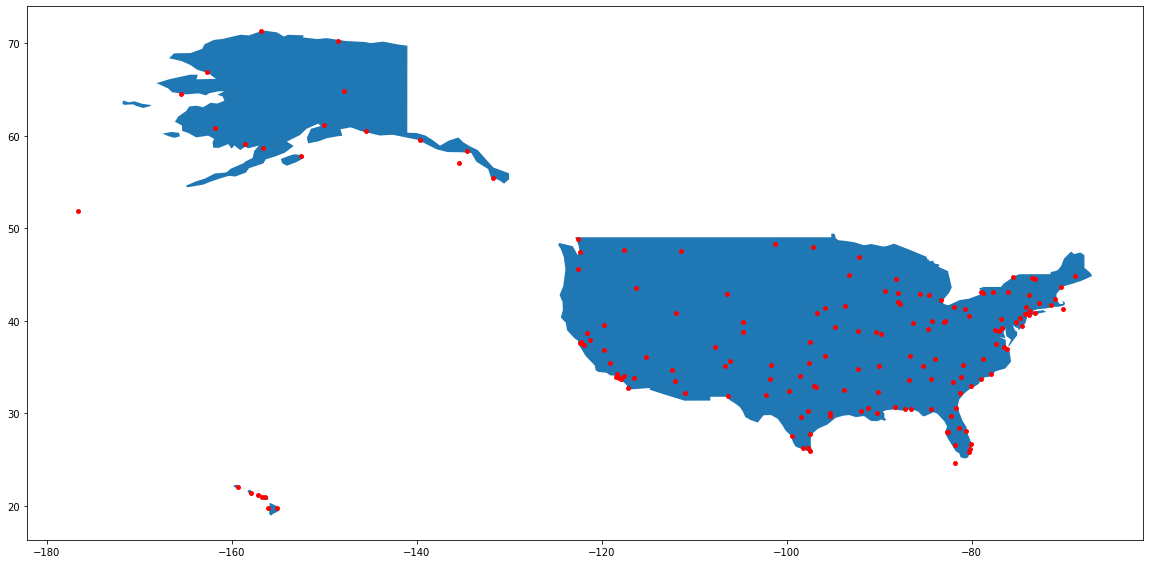

In [19]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us = world[world.name == 'United States of America']

geometry = [Point(xy) for xy in zip(pd_df['lon'], pd_df['lat'])]
gdf = GeoDataFrame(pd_df, geometry=geometry)

ax = us.plot(figsize=(20, 12))
gdf.plot(ax=ax, marker='o', color='red', markersize=15)

In the next two questions, we will want to get an understanding of ticket prices based on flight distance.  
## Question 3 (2 points)
To do that we first need to get and understanding of the flight distance distribution.  
We want to display an histogram of flight distances. To do this :  
- use numpy logspace function to create 10 distance buckets, base=1.05
- then use numpy digitize function inside a spark UDF to create the buckets.
- buckets should be displayed in the correct order, and displayed like this : [min;max]

In [ ]:
distinct_routes_df = flights_df.select('Origin', 'Dest', 'Miles').distinct().cache()

In [ ]:
distinct_routes_df.select(F.max('Miles'), F.min('Miles'), F.count('*')).show()

+----------+----------+--------+
|max(Miles)|min(Miles)|count(1)|
+----------+----------+--------+
|    5095.0|      11.0|    8471|
+----------+----------+--------+



In [11]:
bins = np.unique(np.logspace(47, 177, base=1.05, num=10, dtype='int32'))

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, ArrayType, StringType

def get_bucket_udf(b):
  def bucket(val: int):
    index = int(np.digitize(val, b))
    return [int(b[index-1]), int(b[index])]
  return F.udf(bucket, ArrayType(IntegerType()))

bucket_udf = get_bucket_udf(bins)

In [ ]:
miles_buckets = distinct_routes_df.select(bucket_udf(F.col("Miles")).alias("Miles_Bucket")).groupby("Miles_Bucket").count()

In [12]:
def bucket_to_string(bucket_col_name):
  return F.concat( F.col(bucket_col_name).getItem(0).cast(StringType()), F.lit("-"), F.col(bucket_col_name).getItem(1).cast(StringType()))

In [ ]:
pd_df = (
    miles_buckets
    .withColumn("a", F.col("Miles_Bucket").getItem(0))
    .withColumn("b", F.col("Miles_Bucket").getItem(1))
    .withColumn("bucket", bucket_to_string("Miles_Bucket"))
    .toPandas()
    )

In [ ]:
import seaborn as sns

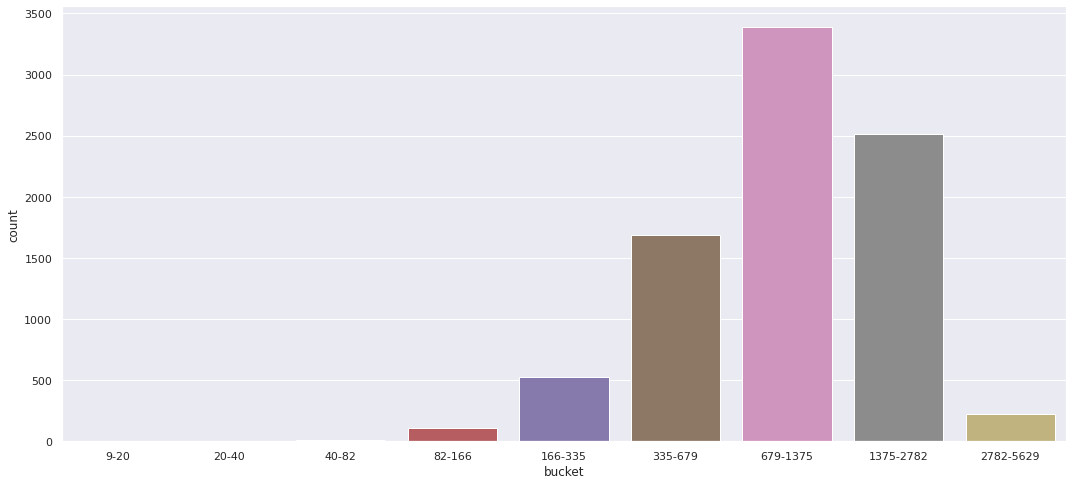

In [ ]:
sns.set(rc={'figure.figsize':(18.0, 8.0)})
sns.barplot(x='bucket', y= "count", data=pd_df.groupby(["bucket"]).agg('sum').reset_index().sort_values("b"))

## Question 4 (3 points)
Display the average flight fares for each distance bucket.  
Graph should also contain the confidence intervals.  
Buckets should be displayed in the correct order, and displayed like this : $[min;max]$  
Interpret the results.  

In [13]:
flights_with_miles_bucket_df = (
    flights_df
      .withColumn("Miles_Bucket", bucket_udf(F.col("Miles")))
      .withColumn("bucket", bucket_to_string("Miles_Bucket"))
      .withColumn("b", F.col("Miles_Bucket").getItem(1))
      )

In [14]:
pd_df = (
    flights_with_miles_bucket_df
      .groupby("bucket", "b")
      .agg(F.mean("PricePerTicket"), F.stddev("PricePerTicket"))
      .toPandas()
      )

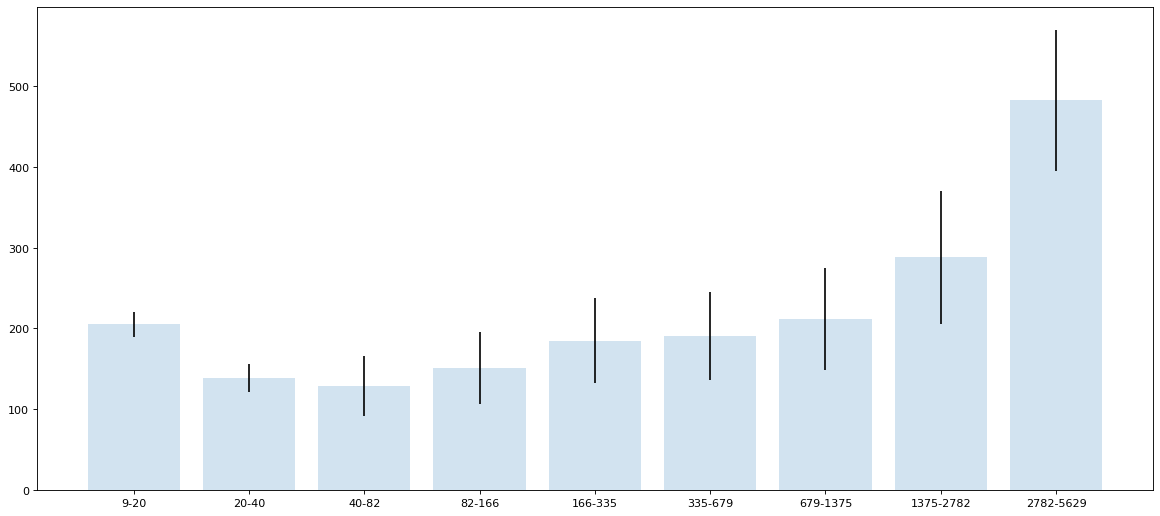

In [30]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

grouped_df = pd_df.groupby(["bucket"]).agg('sum').reset_index().sort_values('b')
labels = grouped_df['bucket'].tolist()
means = grouped_df['avg(PricePerTicket)'].tolist()
stdev = [v / 2 for v in grouped_df['stddev_samp(PricePerTicket)'].tolist()]

figure(figsize=(18, 8), dpi=80)
plt.bar(range(len(means)), means, yerr=stdev, alpha=0.2, align='center')
plt.xticks(range(len(means)), labels)
plt.show()

## Question 5 (4 points)
For the remainder of the notebook, we will only take care of the average price of each route.  
Our goal is to find cheap combinations of flights to travel from one place to another.  
First, we want to build a dataframe named 'cheapest_routes_df' containing the cheapest price to go from one place to another, with one or zero waypoint. Dataframe should look like this (Waypoints column can be empty) :  

Origin  | Destination | Waypoints | TotalPrice
-------------------|------------------|---|---
ACY       | MOB | ATL | 323.0
Row 2, Col 1       | Row 2, Col 2 | | 89.0
  
Is it interesting to consider waypoints to go from one place to another ?  

In [33]:
average_route_prices_df = flights_df.groupby('Origin', 'Dest').agg(F.mean('PricePerTicket').alias('Price'))

In [34]:
all_possible_routes_df = (
    average_route_prices_df
      .withColumnRenamed('Dest', 'Waypoint')
      .join(
          average_route_prices_df
            .withColumnRenamed('Origin', 'Waypoint')
            .withColumnRenamed('Price', 'Price2')
          , on = 'Waypoint'
      )
      .filter('Origin!=Dest')
      .withColumn('TotalPrice', F.col('Price')+F.col('Price2'))
      .select('Origin', 'Dest', 'Waypoint', 'TotalPrice')
      .cache()
)
all_possible_routes_df = (
    all_possible_routes_df.union(
        average_route_prices_df
          .withColumn('Waypoint', F.lit(''))
          .withColumn('TotalPrice', F.col('Price'))
          .select('Origin', 'Dest', 'Waypoint', 'TotalPrice')
    )
)
all_possible_routes_df = all_possible_routes_df.cache()
all_possible_routes_df.show(5)

+------+----+--------+------------------+
|Origin|Dest|Waypoint|        TotalPrice|
+------+----+--------+------------------+
|   JFK| MCO|     PSE|394.37987576707576|
|   MCO| JFK|     PSE|390.51379116564965|
|   BUF| ABQ|     MSY|446.40874999999994|
|   BUF| DEN|     MSY|400.57867499859674|
|   BUF| TUS|     MSY|426.75272727272727|
+------+----+--------+------------------+
only showing top 5 rows



In [37]:
# This solution shuffles only once
cheapest_routes_df = (
    all_possible_routes_df
      .withColumn('PriceAndWaypoint', F.struct(F.col('TotalPrice'), F.col('Waypoint')))
      .groupby('Origin', 'Dest')
      .agg(F.min('PriceAndWaypoint').alias('PriceAndWaypoint'))
      .withColumn('TotalPrice', F.col('PriceAndWaypoint').getField('TotalPrice'))
      .withColumn('Waypoint', F.col('PriceAndWaypoint').getField('Waypoint'))
      .drop('PriceAndWaypoint')
      .cache()
)
cheapest_routes_df.show(5)
cheapest_routes_df.count()

+------+----+--------------------+-----------------+--------+
|Origin|Dest|    PriceAndWaypoint|       TotalPrice|Waypoint|
+------+----+--------------------+-----------------+--------+
|   ABE| MSO|{615.817474747474...|615.8174747474748|     ATL|
|   ABI| SMF|{948.453988818667...|948.4539888186678|     DFW|
|   ACK| SJU|{468.282758956070...|468.2827589560707|     DCA|
|   ADK| AKN|{856.246208791208...|856.2462087912088|     ANC|
|   ALB| MOB|{467.488690330477...|467.4886903304773|     ORD|
+------+----+--------------------+-----------------+--------+
only showing top 5 rows



48687

We can find some routes where we go through a waypoint to reach our destination. It either means that the route was not covered in our initial dataset, or that it's cheaper to go through a waypoint than taking the direct flight.  
Also we can see some direct routes.

## Question 6 (6 points)
Now we want to create the dataframe with cheap combinations of flights from one place to another, but there is no longer any limitation on the amount of waypoints.  
Let $Routes_{k}$ designate the dataframe that contains cheapest routes for at most $k$ waypoints.  
This dataframe contains a column named 'Waypoints', containing an array of waypoints.  
Then:  
- Define a function that computes $Routes_{k+1}$ from $Routes_{k}$ and $Routes_{0}$.  
- Test it on a simple dataset made of three rows, built with $spark.sparkContext.parallelize$.  
- Use it iteratively to build what we want.  
- At each step, measure the amount of routes with k waypoints.  
- What is the stopping criterion ?  
- Measure the execution time of each step.  
- What if we want to execute the iterations up to $k=15$ ?  
- Explain what happens, and find a solution to approximately have the same execution time at each iteration.  
- Analyze the results obtained for $Routes_{maxK}$
- Analyze the euros spared, putting them in front of the extra miles traveled.

In [43]:
from pyspark.sql.types import ArrayType, StringType
def empty_string_array():
    return []
empty_string_array_udf = F.udf(empty_string_array, ArrayType(StringType()))

routes_0_df = (
    average_route_prices_df
    .withColumn("Waypoints", empty_string_array_udf())
    .withColumnRenamed('Price', 'TotalPrice')
    .select('Origin', 'Dest', 'Waypoints', 'TotalPrice')
    .cache()
)

In [45]:
def computeNextRoutes(routes_k_df, routes_0_df, use_cache=False, use_checkpoint=False):
  all_possible_routes_df = (
    routes_k_df
      .withColumnRenamed('Dest', 'Waypoint_k')
      .withColumnRenamed('TotalPrice', 'Price1')
      .join(
          routes_0_df
            .withColumnRenamed('Origin', 'Waypoint_k')
            .withColumnRenamed('TotalPrice', 'Price2')
            .drop('Waypoints')
          , on = 'Waypoint_k'
      )
      .filter('Origin!=Dest')
      .withColumn('TotalPrice', F.col('Price1')+F.col('Price2'))
      .withColumn('Waypoints', F.concat(F.col('Waypoints'), F.array('Waypoint_k')))
      .select('Origin', 'Dest', 'Waypoints', 'TotalPrice')
      )

  all_possible_routes_df = all_possible_routes_df.union(routes_0_df)

  returned_df = (
    all_possible_routes_df
      .withColumn('PriceAndWaypoint', F.struct(F.col('TotalPrice'), F.col('Waypoints')))
      .groupby('Origin', 'Dest')
      .agg(F.min('PriceAndWaypoint').alias('PriceAndWaypoint'))
      .withColumn('TotalPrice', F.col('PriceAndWaypoint').getField('TotalPrice'))
      .withColumn('Waypoints', F.col('PriceAndWaypoint').getField('Waypoints'))
      .drop('PriceAndWaypoint')
      )

  if use_cache:
    returned_df = returned_df.cache()
  if use_checkpoint:
    returned_df = returned_df.localCheckpoint()

  return returned_df

In [46]:
test_rdd = (spark.sparkContext.parallelize([
                                       ('LA', 'NY', 200.0),
                                       ('LA', 'ORD', 50.0),
                                       ('ORD', 'NY', 50.0)
                                       ]))
test_df = (
    spark
      .createDataFrame(test_rdd)
      .toDF('Origin', 'Dest', 'TotalPrice')
      .withColumn("Waypoints", empty_string_array_udf())
      .select('Origin', 'Dest', 'Waypoints', 'TotalPrice')
      )

In [47]:
computeNextRoutes(test_df, test_df).show()

+------+----+----------+---------+
|Origin|Dest|TotalPrice|Waypoints|
+------+----+----------+---------+
|    LA|  NY|     100.0|    [ORD]|
|    LA| ORD|      50.0|       []|
|   ORD|  NY|      50.0|       []|
+------+----+----------+---------+



In [48]:
routes_df = []
routes_df.append(routes_0_df)
routes_df.append(computeNextRoutes(routes_0_df, routes_0_df))

In [49]:
# Stop when we don't find interesting routes with k waypoints
k = 1
start = time.time()
while routes_df[k].filter(F.size('Waypoints')==k).count() > 0:
  next_df = computeNextRoutes(routes_df[k], routes_0_df, use_cache=True)
  routes_df.append(next_df)
  end = time.time()
  print(f"k={k} : {end-start}")
  start = end
  k += 1

k=1 : 31.200052738189697
k=2 : 36.06145167350769
k=3 : 22.678329944610596
k=4 : 22.223594665527344
k=5 : 22.75383496284485


In [ ]:
# Execution time will grow exponentially if we try to iterate too much, because of dataframe lineage.
k = 1
start = time.time()
while k<15:
  next_df = computeNextRoutes(routes_df[k], routes_0_df, use_cache=True)
  routes_df.append(next_df)
  end = time.time()
  print(f"k={k} : {end-start}")
  start = end
  k += 1

In [ ]:
# We can rely on localCheckpoint() function to make things linear again.
k = 1
start = time.time()
while k<15:
  next_df = computeNextRoutes(routes_df[k], routes_0_df, use_checkpoint=True)
  routes_df.append(next_df)
  end = time.time()
  print(f"k={k} : {end-start}")
  start = end
  k += 1